In [1]:
import json
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from xgboost import XGBClassifier


In [2]:
# Load Data
if os.path.exists('data.joblib') and os.path.exists('labels.joblib'):
    data = joblib.load('data.joblib')
    labels = joblib.load('labels.joblib')
else:
    print("Error: Data files not found.")
    exit()

In [3]:
# Convert labels to numerical values
label_dict = {label: idx for idx, label in enumerate(set(labels))}
numeric_labels = np.array([label_dict[label] for label in labels])
X = np.array(data)
y = np.array(numeric_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

In [4]:
# Counting samples per genre in training set
train_genre_counts = {label: np.sum(y_train == idx) for label, idx in label_dict.items()}

# Counting samples per genre in testing set
test_genre_counts = {label: np.sum(y_test == idx) for label, idx in label_dict.items()}

# Convert counts to a list of lists for tabulate
table_data = []

for label, count in train_genre_counts.items():
    table_data.append([label, count, test_genre_counts[label]])

# Headers for the table
headers = ["Genre", "Training Samples", "Testing Samples"]

# Print the table
print("Training and Testing Set Samples per Genre:")
print(tabulate(table_data, headers=headers, tablefmt="grid"))

Training and Testing Set Samples per Genre:
+-----------+--------------------+-------------------+
| Genre     |   Training Samples |   Testing Samples |
+===========+====================+===================+
| rock      |                787 |               213 |
+-----------+--------------------+-------------------+
| country   |                816 |               184 |
+-----------+--------------------+-------------------+
| hiphop    |                803 |               197 |
+-----------+--------------------+-------------------+
| blues     |                794 |               206 |
+-----------+--------------------+-------------------+
| jazz      |                796 |               204 |
+-----------+--------------------+-------------------+
| classical |                798 |               202 |
+-----------+--------------------+-------------------+
| noise     |                822 |               178 |
+-----------+--------------------+-------------------+
| metal     |        

In [5]:

def build_cnn_model(input_shape, filters=64, kernel_size=5, dropout_rate=0.5, l2_reg=0.001):
    model = Sequential()
    model.add(Conv1D(filters, kernel_size, padding='same', activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())

    model.add(Conv1D(filters * 2, kernel_size, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())

    model.add(Conv1D(filters * 4, kernel_size, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(label_dict), activation='softmax'))  # Assuming label_dict is defined

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Assuming X_train_cnn, y_tzrain_onehot, X_test_cnn, y_test_onehot are defined
cnn_model = build_cnn_model(input_shape=(X_train_cnn.shape[1], 1))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=0.00001
)

history = cnn_model.fit(
    X_train_cnn, y_train_onehot, epochs=50, batch_size=64,  # Increased epochs and batch size
    validation_data=(X_test_cnn, y_test_onehot),
    callbacks=[early_stopping, reduce_lr]
)

c:\Users\gvbpena\Desktop\thesis\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.2857 - loss: 2.9563 - val_accuracy: 0.3682 - val_loss: 2.5644 - learning_rate: 1.0000e-04
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4756 - loss: 2.1802 - val_accuracy: 0.5155 - val_loss: 2.1881 - learning_rate: 1.0000e-04
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5185 - loss: 2.0387 - val_accuracy: 0.5550 - val_loss: 1.9632 - learning_rate: 1.0000e-04
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5535 - loss: 1.9375 - val_accuracy: 0.5836 - val_loss: 1.8628 - learning_rate: 1.0000e-04
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5858 - loss: 1.8517 - val_accuracy: 0.6114 - val_loss: 1.7776 - learning_rate: 1.0000e-04
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5988 - loss: 1.8052 - val_accuracy: 0.6355 - val_loss: 1.7262 - learning_rate: 1.0000e-04
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - acc

In [6]:
print(cnn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 38, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 19, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 19, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 9, 256)         │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 9, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,415,971 (5.40 MB)

 Trainable params: 471,691 (1.80 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 943,384 (3.60 MB)

None


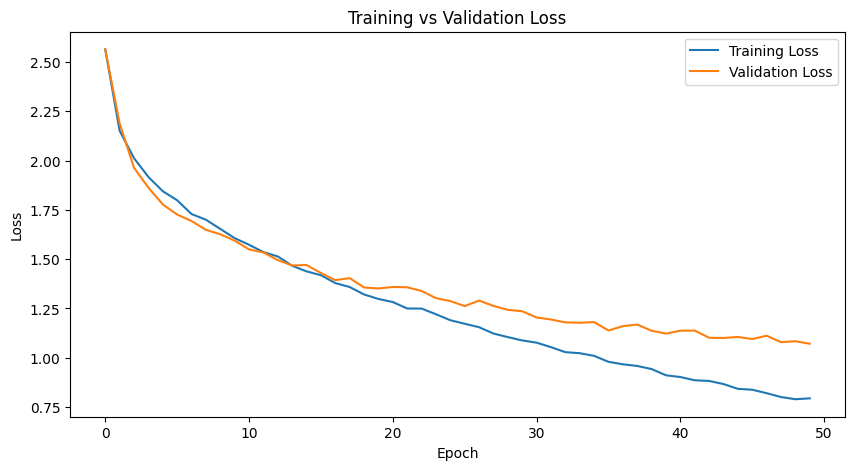

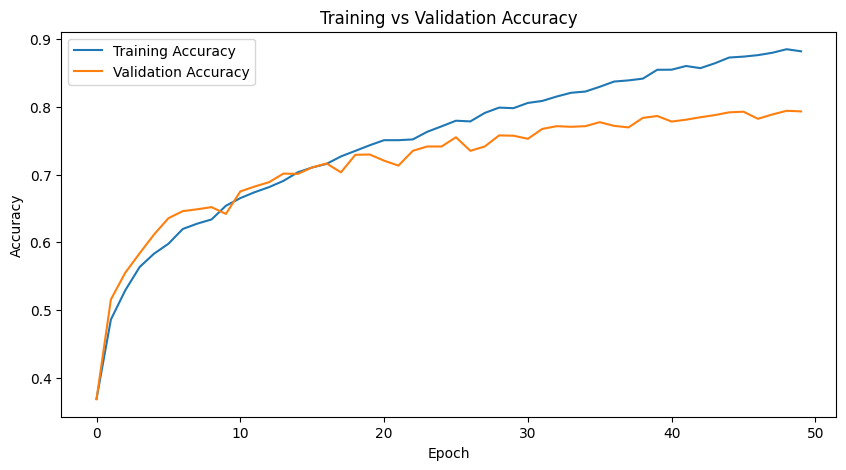

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7902 - loss: 1.0772
Highest Training Accuracy: 0.8850 at Epoch 49, Validation Accuracy: 0.7941
Minimum Training Loss: 0.7897 at Epoch 49, Validation Loss: 1.0837
Test Accuracy: 79.32%


In [7]:

# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training vs validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Find the epoch with the highest training accuracy and corresponding validation accuracy
max_train_accuracy_epoch = np.argmax(history.history['accuracy']) + 1
max_train_accuracy = np.max(history.history['accuracy'])
corresponding_val_accuracy = history.history['val_accuracy'][max_train_accuracy_epoch - 1]

# Find the epoch with the minimum training loss and corresponding validation loss
min_train_loss_epoch = np.argmin(history.history['loss']) + 1
min_train_loss = np.min(history.history['loss'])
corresponding_val_loss = history.history['val_loss'][min_train_loss_epoch - 1]

# Calculate test accuracy
test_loss, test_accuracy = cnn_model.evaluate(X_test_cnn, y_test_onehot)

# Print the results
print(f"Highest Training Accuracy: {max_train_accuracy:.4f} at Epoch {max_train_accuracy_epoch}, Validation Accuracy: {corresponding_val_accuracy:.4f}")
print(f"Minimum Training Loss: {min_train_loss:.4f} at Epoch {min_train_loss_epoch}, Validation Loss: {corresponding_val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


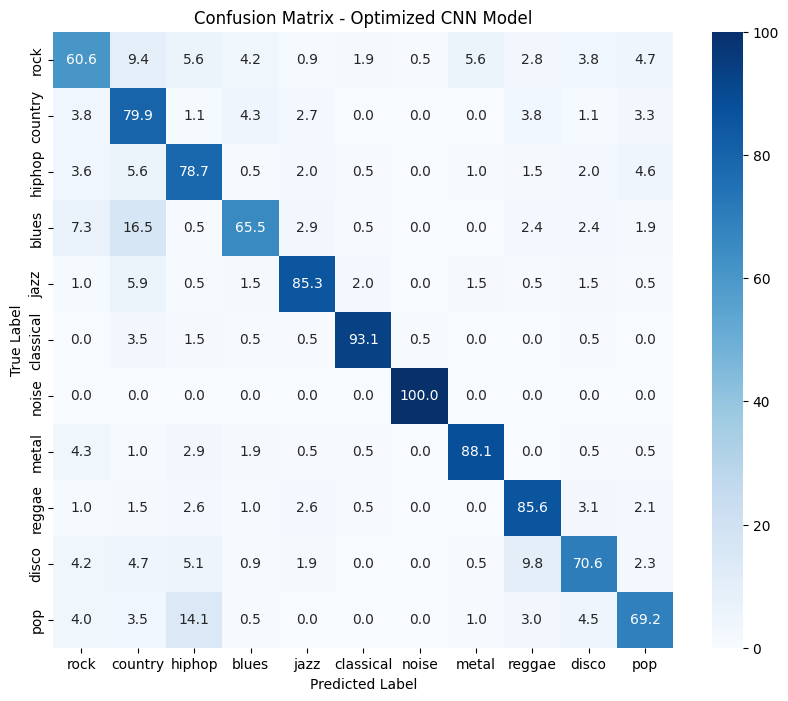

In [8]:


y_pred = np.argmax(cnn_model.predict(X_test_cnn), axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Compute confusion matrix with percentages
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.title('Confusion Matrix - Optimized CNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [9]:
# cnn_features to extract to svm and random forest
cnn_features_train = cnn_model.predict(X_train_cnn)
cnn_features_test = cnn_model.predict(X_test_cnn)



# Scale CNN features for SVM
scaler = StandardScaler()
cnn_features_train_scaled = scaler.fit_transform(cnn_features_train)
cnn_features_test_scaled = scaler.transform(cnn_features_test)

# svm_model = SVC(kernel='rbf', C=1.0, gamma='auto').fit(cnn_features_train_scaled, y_train)

# Train SVM model
svm_model = SVC()
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.1, 1, 'auto']}
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=3, scoring='accuracy')
svm_model.fit(cnn_features_train_scaled, y_train)
svm_predictions = svm_model.predict(cnn_features_test_scaled)

# Train Random Forest model with the same scaled features
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,  # Increase max_depth
    min_samples_split=10,  # Increase min_samples_split
    min_samples_leaf=5,  # Increase min_samples_leaf
    random_state=42
)

# Train the Random Forest model
rf_model.fit(cnn_features_train_scaled, y_train)

# Predictions for SVM and Random Forest
svm_predictions = svm_model.predict(cnn_features_test_scaled)
rf_predictions = rf_model.predict(cnn_features_test_scaled)

# print("SVM Prediction: ", svm_predictions)
# print("Random Forest Prediction: ", rf_predictions)
# print("Random Forest Confidence Levels: ", rf_model.predict_proba(cnn_features_test_scaled))


ensemble_input = np.column_stack((svm_predictions, rf_predictions, np.argmax(cnn_model.predict(X_test_cnn), axis=1)))

xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1).fit(ensemble_input, y_test)

# ensemble_predictions = xgb_model.predict(ensemble_input)
# ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)

# Evaluate the models
svm_accuracy = accuracy_score(y_test, svm_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)
xgb_accuracy = accuracy_score(y_test, xgb_model.predict(ensemble_input))


print(f"SVM Model Accuracy: {svm_accuracy:.4f}")
print(f"Random Forest Model Accuracy: {rf_accuracy:.4f}")
print(f"XGBoost Model Accuracy: {xgb_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
SVM Model Accuracy: 0.8064
Random Forest Model Accuracy: 0.8059
XGBoost Model Accuracy: 0.8141


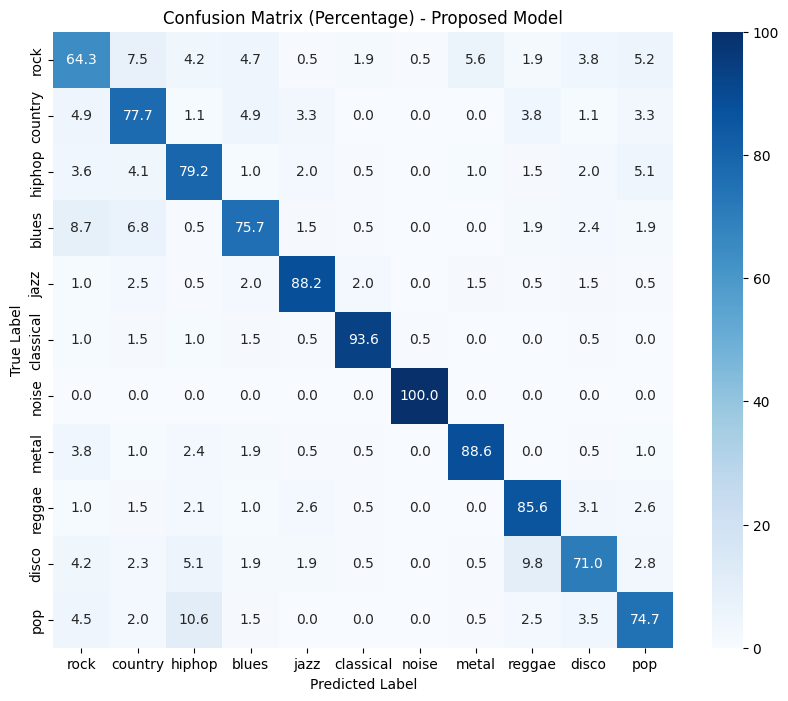

In [10]:


# Predictions for the ensemble model
ensemble_predictions = xgb_model.predict(ensemble_input)

# Compute confusion matrix for ensemble predictions
conf_matrix_ensemble = confusion_matrix(y_test, ensemble_predictions)

# Compute confusion matrix with percentages for ensemble predictions
conf_matrix_ensemble_percentage = conf_matrix_ensemble.astype('float') / conf_matrix_ensemble.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages for ensemble predictions
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_ensemble_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.title('Confusion Matrix (Percentage) - Proposed Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [11]:


# Predictions for ensemble model
ensemble_predictions = xgb_model.predict(ensemble_input)

# Calculate precision, recall, F1-score, and accuracy for the ensemble model
ensemble_report = classification_report(y_test, ensemble_predictions)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)

print("Proposed Model Metrics:")
print(ensemble_report)
print("Proposed Model Accuracy:", ensemble_accuracy)


Proposed Model Metrics:
              precision    recall  f1-score   support

           0       0.67      0.64      0.66       213
           1       0.70      0.78      0.74       184
           2       0.74      0.79      0.76       197
           3       0.79      0.76      0.77       206
           4       0.88      0.88      0.88       204
           5       0.94      0.94      0.94       202
           6       0.99      1.00      0.99       178
           7       0.91      0.89      0.90       210
           8       0.79      0.86      0.82       194
           9       0.80      0.71      0.75       214
          10       0.77      0.75      0.76       198

    accuracy                           0.81      2200
   macro avg       0.82      0.82      0.82      2200
weighted avg       0.81      0.81      0.81      2200

Proposed Model Accuracy: 0.8140909090909091


In [12]:
saved_folder = 'new'

# Create the folder if it doesn't exist
if not os.path.exists(saved_folder):
    os.makedirs(saved_folder)

# Save models
joblib.dump(xgb_model, os.path.join(saved_folder, 'xgb_model.joblib'))
joblib.dump(svm_model, os.path.join(saved_folder, 'svm_model.joblib'))
joblib.dump(rf_model, os.path.join(saved_folder, 'rf_model.joblib'))
# Save CNN model
cnn_model.save(os.path.join(saved_folder, 'cnn_model.h5'))

# baseline_cnn_model.save(os.path.join(saved_folder, 'baseline_cnn_model.h5'))


# Save data arrays
np.save(os.path.join(saved_folder, 'ensemble_input.npy'), ensemble_input)
np.save(os.path.join(saved_folder, 'y_test.npy'), y_test)
np.save(os.path.join(saved_folder, 'X_test.npy'), X_test)
np.save(os.path.join(saved_folder, 'X_test_cnn.npy'), X_test_cnn)

# Save label dictionary
with open(os.path.join(saved_folder, 'label_dict.json'), 'w') as json_file:
    json.dump(label_dict, json_file)
